## Import Libraries and Load Data

In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/NLP_VINAI/Lesson10/Home/

/content/drive/MyDrive/NLP_VINAI/Lesson10/Home


In [ ]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Xử lý dữ liệu với các giá trị missing

In [ ]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<br>
Loại bỏ tất cả các hàng dữ liệu bị missing values.

In [ ]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Chuẩn bị dữ liệu

Chuyển StockCode thành kiểu dữ liệu string

In [ ]:
df['StockCode']= df['StockCode'].astype(str)

Kiểm tra số lượng khách hàng trong tập dataset

In [ ]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

Có tổng cộng 4,372 khác hàng trong bộ dataset. Với mỗi khách hàng chúng ta sẽ trích xuất lịch sử mua bán của họ. Hay nói cách khác chúng ta sẽ có 4,372 chuỗi mua hàng.

Với tập dữ liệu đầu vào, chúng ta sử dụng dữ liệu của 80% khách hàng để tạo word2vec embeddings, số còn lại ta dùng để đánh giá. Vì vậy ta chia tập dữ liệu như sau:

In [ ]:
# Trộn ID của khách hàng
random.shuffle(customers)

# Lấy 80% ID của khác hàng
customers_train = [customers[i] for i in range(round(0.8*len(customers)))]

# Chia tập dữ liệu thành bộ train và validation
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

Tạo chuỗi mua hàng của các khách hàng trong hai tập train và validation

In [ ]:
purchases_train = []

# điền mã sản phẩm vào danh sách tập train
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3498/3498 [00:03<00:00, 1099.34it/s]


In [ ]:
purchases_val = []

# điền mã sản phẩm vào danh sách tập validation
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 874/874 [00:00<00:00, 1390.77it/s]


## Câu hỏi 2: Xây dựng mô hình biểu diễn cho các sản phẩm trong bộ dữ liệu train:
- Xây dựng mô hình, sử dụng Word2Vec(), với các tham số: window = 8, sg = 1, hs = 0, negative = 10, alpha=0.03, min_alpha=0.0007, seed = 14
- Xây dựng vocab cho mô hình, sử dụng build_vocab() cho model với bộ dữ liệu train và tham số progress_per=200
- Training cho model, sử dụng train() trên tập dữ liệu train, với các tham số total_examples = model.corpus_count, epochs=10, report_delay=1

In [ ]:
# train word2vec model
model = Word2Vec(window = 8, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3162129, 3198160)

In [ ]:
# save word2vec model
model.save("word2vec_2.model")

Vì chúng ta không train mô hình thêm nữa, nên chúng ta gọi init_sims(), để giúp mô hình thêm hiệu quả về bộ nhớ.

In [ ]:
model.init_sims(replace=True)

In [ ]:
print(model)

Word2Vec(vocab=3097, size=100, alpha=0.03)


Bây giờ ta sẽ trích xuất vector của tất cả các từ trong vocab, và lưu chúng lại một nơi để dễ dàng truy cập.

Lưu ý: sử dụng phù hợp version của Gensim

In [ ]:
# extract all vectors
X = model[model.wv.vocab]
#X = model[model.wv.key_to_index]
X.shape

(3097, 100)

## Visualize word2vec Embeddings

Visualize kết quả word2vec sử dụng thuật toán UMAP. Ở đây, vì mỗi vector có số chiều là 100, nên ta chuyển chúng về 2 chiều để hiển thị.

In [ ]:
!pip uninstall umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 27.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=aedc4479e7ff1f3f319ce2720f587839c04f8f4239a35e76a1730ec970659566
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=305ad8f3338148b576a0a6304591d27a2cf8e0ed374411b08c5ac1ca728220a7
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


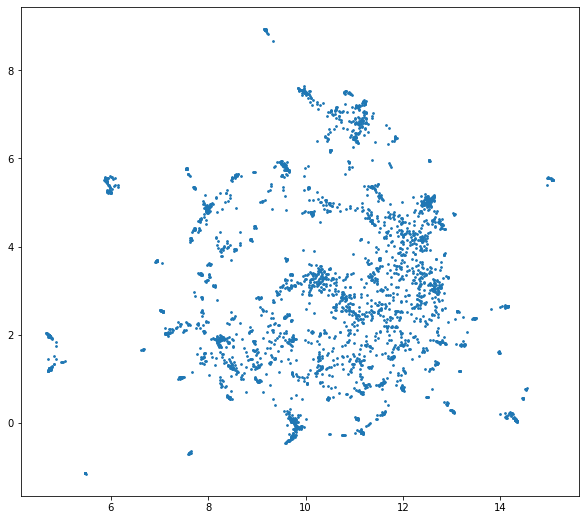

In [ ]:
import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

## Bắt đầu gợi ý các sản phẩm

Đến đây, chúng ta đã có word2vec embeddings cho từng sản phẩm trong bộ dữ liệu Online Retail. Bước tiếp theo, ta sẽ gợi ý các sản phẩm tương tự cho một sản phẩm.

Đầu tiên, tạo một từ điển về ID và mô tả của phẩm để dễ dàng map một mô tả sản phẩm với ID của nó và ngược lại.

In [ ]:
products = train_df[["StockCode", "Description"]]

# Loại bỏ sự trùng lặp
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")
# Tạo từ điển
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [ ]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

## Câu hỏi 3: Xây dựng hàm tính similarity của sản phẩm

Hàm nhận vào là vector của một sản phẩm cần gợi ý, đầu ra là 10 sản phẩm tương tự mà hệ thống sẽ gợi ý

In [ ]:
def similar_products(v, n = 10):
    

    ms = model.similar_by_vector(v, topn= n+1)[1:]
    

    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

Thử hàm trên với một sản phẩm: '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [ ]:
similar_products(model['90019A'])

[('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.8114911913871765),
 ('ANT COPPER RED BOUDICCA BRACELET', 0.8079259395599365),
 ('GREEN HEART OF GLASS BRACELET', 0.7847134470939636),
 ('PINK BOUDICCA LARGE BRACELET', 0.7840222716331482),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7769255042076111),
 ('PINK HEART OF GLASS BRACELET', 0.7748823165893555)]

## Câu hỏi 4:
Các kết quả trên khá tốt. Tuy nhiên, kết quả này dựa trên vector của chỉ một sản phẩm. Điều gì xảy ra nếu ta muốn gợi ý một khách hàng các sản phẩm dựa trên các sản phẩm khách hàng đã lựa chọn trước đó?

In [ ]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [ ]:
len(purchases_val[0])

359

In [ ]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [ ]:
similar_products(aggregate_vectors(purchases_val[0]))

[('JUMBO BAG RED RETROSPOT', 0.7196784019470215),
 ('TOY TIDY PINK POLKADOT', 0.7042723298072815),
 ('LUNCH BAG RED RETROSPOT', 0.7027850151062012),
 ('POSY CANDY BAG', 0.6991532444953918),
 ('LUNCH BAG CARS BLUE', 0.6973865032196045),
 ('JUMBO BAG OWLS', 0.6965253949165344)]

In [ ]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('TOY TIDY PINK POLKADOT', 0.7080984115600586),
 ('JUMBO STORAGE BAG SKULLS', 0.70808345079422),
 ('JUMBO BAG RED RETROSPOT', 0.7008751630783081),
 ('POSY CANDY BAG', 0.6862739324569702),
 ('JUMBO BAG PINK POLKADOT', 0.6768118143081665),
 ('JUMBO SHOPPER VINTAGE RED PAISLEY', 0.6765967607498169)]